In [2]:
from pathlib import Path
import shutil
import json
import os

from PIL import Image, ImageDraw

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
root = Path('./data/tusimple')
ptrain = root / 'train_set'
pimages = root / 'train_set_preprocessed/images'
plabels = root / 'train_set_preprocessed/labels'

In [3]:
shutil.rmtree(pimages)
shutil.rmtree(plabels)
os.makedirs(pimages, exist_ok=True)
os.makedirs(plabels, exist_ok=True)
list(ptrain.glob('*.json')) 

[WindowsPath('data/tusimple/train_set/label_data_0313.json'),
 WindowsPath('data/tusimple/train_set/label_data_0531.json'),
 WindowsPath('data/tusimple/train_set/label_data_0601.json')]

# 1280x720 -> 320x180

In [4]:
count = 0
f_filenames = open(pimages.parent / 'filenames.txt', 'w')
filenames = ''
for plabel in ptrain.glob('*.json'):
    with open(plabel, 'r') as f:
        for line in f.readlines():  # for each image
            label = json.loads(line.strip())
            # 'lanes': 각 lane의 x 좌표들, -2이면 무시
            # 'h_samples': y 값들
            # 'raw_file': 이미지 경로, clip/...
            
            # x, y 나눠져 있는 점들을 [[x1, y1], [x2, y2], ...] 꼴로 바꿈
            lanes = np.array(label['lanes'])
            lanes = lanes.reshape(-1)
            num_lanes = lanes.shape[0] // 48
            h_samples = np.array(label['h_samples'])
            h_samples = np.tile(h_samples, num_lanes)
            valid_idx = lanes!=-2
            x = np.c_[lanes[valid_idx], h_samples[valid_idx]]
            x //= 4  # 가로, 세로 각각 1/4씩 줄어듦
            
            # 이미지 resize
            image = Image.open(ptrain / label['raw_file']).convert('RGB')
            image = image.resize((320, 180), Image.BICUBIC)
            
            # 저장
            filename = Path('_'.join(label['raw_file'].split('/')[1:]))
            np.save(plabels / filename.with_suffix('.npy'), x)
            image.save(pimages / filename.with_suffix('.jpg'))
            filenames += str(filename.stem) + '\n'
            count += 1
            if count % 500 == 0:
                print(f'\r{count} done')
f_filenames.write(filenames.strip())
f_filenames.close() 

500 done
1000 done
1500 done
2000 done
2500 done
3000 done
3500 done


# Validate

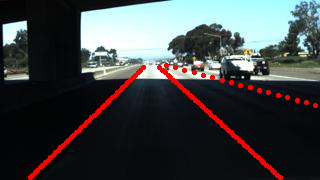

In [5]:
import random
with open(pimages.parent / 'filenames.txt', 'r') as f:
    filename = Path(random.choice(f.readlines()).strip()) 
image = Image.open(pimages / filename.with_suffix('.jpg')).convert('RGB')
label = np.load(plabels / filename.with_suffix('.npy'))

r = 2
draw = ImageDraw.Draw(image)
for cx, cy in label:
    leftUpPoint = (cx-r, cy-r)
    rightDownPoint = (cx+r, cy+r)
    twoPointList = [leftUpPoint, rightDownPoint]
    draw.ellipse(twoPointList, fill=(255,0,0,255))
image

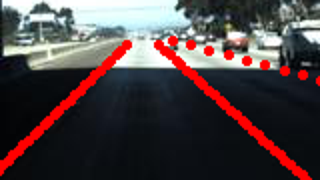

In [6]:
image.crop((80, 45, 240, 135)).resize((320, 180))  # left, top, right, bottom

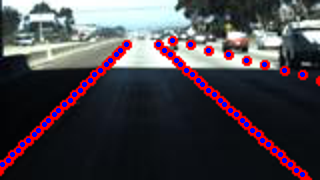

In [7]:
boxes = [
    # left, top, right, bottom
    ( 80, 45, 240, 135),  # center
    (  0,  0, 160,  90),  # leftupper
    (  0, 90, 160, 180),  # leftbottom
    (160,  0, 320,  90),  # rightupper
    (160, 90, 320, 180),  # rightbottom
]
box = left, top, right, bottom = random.choice(boxes)
labelx = label[:,0]
labely = label[:,1]
newlabel_idx = (left <= labelx) & (labelx < right) & (top  <= labely) & (labely < bottom)
newlabel = label[newlabel_idx]
newlabel -= np.array([[left, top]])
newlabel *= 2

newimage = image.crop(box).resize((320, 180))
draw = ImageDraw.Draw(newimage)
for cx, cy in newlabel:
    leftUpPoint = (cx-r, cy-r)
    rightDownPoint = (cx+r, cy+r)
    twoPointList = [leftUpPoint, rightDownPoint]
    draw.ellipse(twoPointList, fill=(0,0,255,255))
newimage

# Guide to build torch.Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms

In [ ]:
root = Path('./data/tusimple')
ptrain = root / 'train_set'
pimages = root / 'train_set_preprocessed/images'
plabels = root / 'train_set_preprocessed/labels'
boxes = [
    # left, top, right, bottom
    ( 80, 45, 240, 135),  # center
    (  0,  0, 160,  90),  # leftupper
    (  0, 90, 160, 180),  # leftbottom
    (160,  0, 320,  90),  # rightupper
    (160, 90, 320, 180),  # rightbottom
]
class TuSimpleDataset(torch.utils.data.Dataset):
    def __init__(self, p_crop=.4):
        super().__init__()
        self.p_crop = p_crop
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5)),
        ])
        with open(pimages.parent / 'filenames.txt', 'r') as f:
            self.filenames = list(map(Path, f.read().split('\n')))
            
    def __getitem__(self, index):
        filename = self.filenames[index]
        image = Image.open(pimages / filename.with_suffix('.jpg')).convert('RGB')
        label = np.load(plabels / filename.with_suffix('.npy'))  # [? x 2]
        
        if random.random() < self.p_crop:  # crop
            box = left, top, right, bottom = random.choice(boxes)
            image = image.crop(box).resize((320, 180))
            labelx = label[:,0]
            labely = label[:,1]
            idx = (left <= labelx) & (labelx < right) & (top  <= labely) & (labely < bottom)  # [? x 2]
            label = label[idx]  # [?? x 2]
            label -= np.array([[left, top]])
            label *= 2
        
        tmp = np.zeros((320, 180))
        tmp[label[:,0], label[:,1]] = 1.
        label = tmp.T[None,:,:]  # [1 x 180 x 320]  # 가로세로 왜 바꾼지는 모르겠는데 암튼 바껴있음
        return self.transform(image), label  # [3 x 180 x 320], [1 x 180 x 320]
    
    def __len__(self):
        return len(self.filenames)

In [ ]:
dataset = TuSimpleDataset()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

for batch_idx, (image, label) in enumerate(dataloader):
    break
image.shape, label.shape

# Guild to build the model

In [ ]:
import torch
import torch.nn as nn

In [ ]:
def summarize(name, blocks, x):
    print('='*60)
    print(f'Module [{name}]')
    print(f'\tInput{str(list(x.shape)):>47}')
    with torch.no_grad():
        count_layer = 1
        for i, block in enumerate(blocks):
            x = block(x)
            print(f'\tBlock #{i+1}')
            for layer in block:
                class_name = str(layer.__class__).split(".")[-1].split("'")[0]
                print(f'\t  Layer {f"#{count_layer}":>3} {class_name}')
                count_layer += 1
            print(f'{str(list(x.shape)):>60}')

In [ ]:
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = None
        self.blocks = None
    def build_graph(self, blocks):
        return nn.ModuleList(map(lambda block: nn.Sequential(*block), blocks))
    def __validate(self):
        assert self.name,   '`self.name` is not defined'
        assert self.blocks, '`self.blocks` is not defined. Build one using self.build_graph(blocks)'
    def summarize(self, x):
        self.__validate()
        summarize(self.name, self.blocks, x) 
    def forward(self, x):
        self.__validate()
        for block in self.blocks:
            x = block(x)
        return x

In [ ]:
class Extracter(BaseModel):
    def __init__(self, name='Feature Extracter'):
        super().__init__() 
        self.name = name
        blocks = [
            (
                nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=True),
                nn.InstanceNorm2d(32),
                nn.ReLU(inplace=True),
            ), (
                nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=True),
                nn.ReLU(inplace=True),
            )
        ]
        self.blocks = self.build_graph(blocks)

In [ ]:
x = torch.randn(4, 3, 180, 320)
extracter = Extracter()
f = extracter(x) 
extracter.summarize(x)

In [ ]:
class ModelMuSigma(BaseModel):
    def __init__(self, dim_k, name='MoL MuSigma'):
        super().__init__() 
        self.name = name
        blocks = [
            (
                nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
                nn.InstanceNorm2d(32),
                nn.ReLU(inplace=True),
            ), (    
                nn.ConvTranspose2d(32, dim_k, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
            ),
        ]
        self.blocks = self.build_graph(blocks) 

model_mu = ModelMuSigma()
model_mu.summarize(f)
mu = model_mu(f)

In [ ]:
class ModelPi(BaseModel):
    def __init__(self, dim_k, name='MoL Pi'):
        super().__init__() 
        self.name = name
        blocks = [
            (
                nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True),
                nn.InstanceNorm2d(128),
                nn.LeakyReLU(.2, inplace=True),
            ), (    
                nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=True),
                nn.InstanceNorm2d(128),
                nn.LeakyReLU(.2, inplace=True),
            ), (
                nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=True),
                nn.InstanceNorm2d(256),
                nn.LeakyReLU(.2, inplace=True),
            ), (
                nn.Conv2d(256, dim_k//2, kernel_size=5, stride=5, padding=0, bias=True),
                nn.LeakyReLU(.2, inplace=True),
            ), (
                nn.Flatten(),
                nn.Softmax(1),
            )
        ]
        self.blocks = self.build_graph(blocks) 

model_pi = ModelPi(dim_k=10)
pi = model_pi(f)
model_pi.summarize(f)  
pi, pi.sum(axis=1)

In [ ]:
class MixtureLogitsNetwork(nn.Module):
    def __init__(self,
                 dim_k      = 10,
                 # todo: multi class를 위한 dim_y 추가, SHARE_SIG도 추가
                 sig_min    = 1e-4, 
                 mu_min     = -3,           # minimum mu (init)
                 mu_max     = +3,           # maximum mu (init)
                ):
        super().__init__()
        self.dim_k   = dim_k
        self.sig_min = sig_min
        self.mu_min  = mu_min
        self.mu_max  = mu_max
        self.build_graph()
        self.init_param() 
    def build_graph(self):
        self.extracter   = Extracter()
        self.model_pi    = ModelPi(dim_k=self.dim_k)
        self.model_mu    = ModelMuSigma(dim_k=self.dim_k, name='MoL Mu')
        self.model_sigma = ModelMuSigma(dim_k=self.dim_k, name='MoL Sigma')
    def init_param(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            if isinstance(m, nn.Linear): # init dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
        # Heuristic: fc_mu.bias ~ Uniform(mu_min,mu_max)
        list(self.model_mu.modules())[-1].bias.data.uniform_(self.mu_min,self.mu_max)
    def summarize(self, x):
        self.extracter.summarize(x)
        with torch.no_grad():
            f = self.extracter(x)
        self.model_pi.summarize(f)
        self.model_mu.summarize(f)
        self.model_sigma.summarize(f)
    def forward(self, x):
        f     = self.extracter(x)
        
        pi    = self.model_pi(f)
        mu    = self.model_mu(f)
        sigma = self.sig_min + torch.exp(self.model_sigma(f))
        return {'pi': pi, 'mu': mu, 'sigma': sigma}

x = torch.randn(4, 3, 180, 320)
mln = MixtureLogitsNetwork()
mln.summarize(x)